# CPSC 330 Lecture 18

Lecture plan:

- 👋
- **Turn on recording**
- Announcements
- Our standard approach (10 min)
- Censoring and survival analysis (15 min)
- Kaplan-Meier curve (10 min)
- Break (5 min)
- Cox proportional hazards model (15 min)
- Prediction (10 min)

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer

In [2]:
plt.rcParams['font.size'] = 16

In [3]:
import lifelines

In [4]:
# does lifelines try to mess with this?
pd.options.display.max_rows = 10

## Announcements

- hw7 released, due next Monday 11:59pm
- hw8 will be a free-form ML task, hw9 will be a blog post
- See Piazza for final exam details

## Customer churn: our standard approach (10 min)

- In hw4 you looked at a dataset about [customer churn](https://en.wikipedia.org/wiki/Customer_attrition).
- In hw4, the dataset was interesting because it's unbalanced (most customers stay). 
- Today we'll look at a different customer churn [dataset](https://www.kaggle.com/blastchar/telco-customer-churn), because it has a feature we need - time!
- We'll explore the time aspect of the dataset today.

In [5]:
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df_train, df_test = train_test_split(df, random_state=123)
df_train.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6464,4726-DLWQN,Male,1,No,No,50,Yes,Yes,DSL,Yes,...,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),70.35,3454.6,No
5707,4537-DKTAL,Female,0,No,No,2,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Electronic check,45.55,84.4,No
3442,0468-YRPXN,Male,0,No,No,29,Yes,No,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),98.80,2807.1,No
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
6124,7153-CHRBV,Female,0,Yes,Yes,57,Yes,No,DSL,Yes,...,Yes,Yes,No,No,One year,Yes,Mailed check,59.30,3274.35,No


We are trying to predict `Churn` (yes/no) from these other columns.

In [6]:
df_train.shape

(5282, 21)

In [7]:
df_train["Churn"].value_counts()

No     3912
Yes    1370
Name: Churn, dtype: int64

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5282 entries, 6464 to 3582
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5282 non-null   object 
 1   gender            5282 non-null   object 
 2   SeniorCitizen     5282 non-null   int64  
 3   Partner           5282 non-null   object 
 4   Dependents        5282 non-null   object 
 5   tenure            5282 non-null   int64  
 6   PhoneService      5282 non-null   object 
 7   MultipleLines     5282 non-null   object 
 8   InternetService   5282 non-null   object 
 9   OnlineSecurity    5282 non-null   object 
 10  OnlineBackup      5282 non-null   object 
 11  DeviceProtection  5282 non-null   object 
 12  TechSupport       5282 non-null   object 
 13  StreamingTV       5282 non-null   object 
 14  StreamingMovies   5282 non-null   object 
 15  Contract          5282 non-null   object 
 16  PaperlessBilling  5282 non-null   objec

Question: Does this mean there is no missing data?

Ok, let's try our usual approach:

In [9]:
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
drop_features    = ['customerID']
target_column    = ['Churn']
# the rest are categorical
categorical_features = list(set(df_train.columns)-set(numeric_features)-set(drop_features)-set(target_column))

In [10]:
preprocessing = ColumnTransformer([
    ('scale',  StandardScaler(), numeric_features),
    ('ohe',    OneHotEncoder(), categorical_features) 
])

In [11]:
preprocessing.fit(df_train);

ValueError: could not convert string to float: ''

Hmmm, one of the numeric features is causing problems?

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Oh, looks like `TotalCharges` is not a numeric type.

In [13]:
df_train['TotalCharges'] = df_train['TotalCharges'].astype(float)

ValueError: could not convert string to float: ''

Argh!!

In [14]:
for val in df_train['TotalCharges']:
    try: 
        float(val)
    except ValueError:
        print(val)

Any ideas?

<br><br><br><br><br><br>

Well, it turns out we can't see those problematic values because they are whitespace!

In [15]:
for val in df_train['TotalCharges']:
    try: 
        float(val)
    except ValueError:
        print('"%s"' % val)

" "
" "
" "
" "
" "
" "
" "
" "


In [16]:
df_train = df_train.assign(TotalCharges=df_train['TotalCharges'].replace(" ", np.nan).astype(float))
df_test = df_test.assign(TotalCharges=df_test['TotalCharges'].replace(" ", np.nan).astype(float))

In [17]:
X_train = df_train.drop(columns=["Churn"])
X_test = df_test.drop(columns=["Churn"])

y_train = df_train["Churn"]
y_test = df_test["Churn"]

Now that worked. But now we need to do imputation.

In [18]:
preprocessing = ColumnTransformer([
    ('scale',  make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_features),
    ('ohe',    OneHotEncoder(), categorical_features) 
])

Now let's try that again...

In [19]:
preprocessing.fit(df_train);

In [20]:
new_columns = numeric_features + list(preprocessing.named_transformers_['ohe'].get_feature_names(categorical_features))

In [21]:
X_train_enc = pd.DataFrame(preprocessing.transform(df_train), index=df_train.index, columns=new_columns)
X_test_enc  = pd.DataFrame(preprocessing.transform(df_test),  index=df_test.index,  columns=new_columns)

In [22]:
X_train_enc.head()

,tenure,MonthlyCharges,TotalCharges,Partner_No,Partner_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,DeviceProtection_No,DeviceProtection_No internet service,...,PaperlessBilling_Yes,PhoneService_No,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6464,0.707712,0.185175,0.513678,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5707,-1.248999,-0.641538,-0.979562,1.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3442,-0.148349,1.133562,0.226789,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3932,-1.248999,0.458524,-0.950696,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6124,0.993065,-0.183179,0.433814,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Ok, let's get some scores...

In [23]:
dc = DummyClassifier(strategy='prior')

In [24]:
pd.DataFrame(cross_validate(dc, X_train, y_train, return_train_score=True)).mean()

fit_time       0.004109
score_time     0.002017
test_score     0.740628
train_score    0.740629
dtype: float64

In [25]:
lr = make_pipeline(preprocessing, LogisticRegression(max_iter=1000))

In [26]:
pd.DataFrame(cross_validate(lr, X_train, y_train, return_train_score=True)).mean()

fit_time       0.097240
score_time     0.013919
test_score     0.804429
train_score    0.808690
dtype: float64

In [27]:
confusion_matrix(y_train, cross_val_predict(lr, X_train, y_train))

array([[3516,  396],
       [ 637,  733]])

In [28]:
rf = make_pipeline(preprocessing, RandomForestClassifier())

In [29]:
pd.DataFrame(cross_validate(rf, X_train, y_train, return_train_score=True)).mean()

fit_time       0.430045
score_time     0.032153
test_score     0.790988
train_score    0.998012
dtype: float64

In [30]:
confusion_matrix(y_train, cross_val_predict(rf, X_train, y_train))

array([[3531,  381],
       [ 745,  625]])

And now the rest of the class is about what is wrong with what we just did!

## Censoring and survival analysis (15 min)

#### Time to event and censoring

Imagine that you want to analyze _the time until an event occurs_. For example,

- the time until a disease kills its host.
- the time until a piece of equipment breaks.
- the time that someone unemployed will take to land a new job.
- the time until a customer leaves a subscription service (this dataset).



In [31]:
df_train[["tenure"]].head()

,tenure
6464,50
5707,2
3442,29
3932,2
6124,57


This column is the number of months the customer has stayed with the company.

Although this branch of statistics is usually referred to as **Survival Analysis**, the event in question does not need to be related to actual "survival". The important thing is to understand that we are interested in **the time until something happens**, or whether or not something will happen in a certain time frame.

**Question:** But why is this different? Can't you just use the techniques you learned so far (e.g., regression models) to predict the time? Take a minute to think about this.

<br><br><br><br><br><br>

The answer would be yes if you could observe the actual time in all occurrences, but you usually cannot. Frequently, there will be some kind of **censoring** which will not allow you to observe the exact time that the event happened for all units/individuals that are being studied.

In [32]:
df_train[["tenure", "Churn"]].head()

,tenure,Churn
6464,50,No
5707,2,No
3442,29,No
3932,2,Yes
6124,57,No


- What this means is that we **don't have correct target values** to train or test our model.
- This is a problem!

Let's consider some approaches to deal with this censoring issue.

#### Approach 1

Let's just consider the cases _for which we have the time_, to obtain the average subscription length.

In [33]:
df_train_churn = df_train.query("Churn == 'Yes'")
df_test_churn = df_test.query("Churn == 'Yes'")
df_train_churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
3932,1304-NECVQ,Female,1,No,No,2,Yes,Yes,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,78.55,149.55,Yes
301,8098-LLAZX,Female,1,No,No,4,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,95.45,396.10,Yes
5540,3803-KMQFW,Female,0,Yes,Yes,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.55,20.55,Yes
4084,2777-PHDEI,Female,0,No,No,1,Yes,No,Fiber optic,No,...,No,No,Yes,No,Month-to-month,No,Electronic check,78.05,78.05,Yes
3272,6772-KSATR,Male,0,No,No,1,Yes,Yes,Fiber optic,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,81.70,81.70,Yes


In [34]:
df_train_churn.shape

(1370, 21)

In [35]:
df_train.shape

(5282, 21)

In [36]:
preprocessing_notenure = ColumnTransformer([
    ('scale',  make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_features[1:]),
    ('ohe',    OneHotEncoder(), categorical_features) 
])

tenure_lm = make_pipeline(preprocessing_notenure, Ridge())

In [37]:
tenure_lm.fit(df_train_churn.drop(columns=["tenure"]), df_train_churn["tenure"]);

In [38]:
tenure_lm.predict(df_test_churn.drop(columns=["tenure"]))[:10]

array([ 5.06220341, 13.19842594, 11.86000915,  5.86549339, 58.15531207,
        3.75777597, 18.93218848,  7.72057413, 36.81845697,  7.26344075])

What will be wrong with our estimated survival times? Will they be too low or too high? 
<br><br><br><br><br><br><br>

On average they will be **underestimates** (too small), because we are ignoring the currently subscribed (un-churned) customers. Our dataset is a biased sample of those who churned within the time window of the data collection. Long-time subscribers were more likely to be removed from the dataset! This is a common mistake - see the Calling Bullshit video I posted on the README!

#### Approach 2

Assume everyone churns right now - in other words, use the original dataset. 

In [39]:
tenure_lm.fit(df_train.drop(columns=["tenure"]), df_train["tenure"]);

In [40]:
tenure_lm.predict(df_test.drop(columns=["tenure"]))[:10]

array([20.56929697, 40.65520509, 31.52902413, 36.16312437, 41.8706012 ,
       37.98663577, 17.47753169, 54.68983917, 48.1412576 , 71.23988875])

What will be wrong with our estimated survival time?
<br><br><br><br><br><br>

It will be an **underestimate** again. For those still subscribed, while we did not remove them, we recorded a total tenure shorter than in reality, because they will keep going for some amount of time. because we have a bunch of churns "now" that did not actually happen.

#### Approach 3

Deal with this properly using [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).

- You may learn about this in a statistics course.
- We will use the `lifelines` package in Python and will not go into the math/stats of how it works.

#### Types of questions we might want to answer:

1. How long do customers stay with the service? 
2. What factors influence a customer's churn time?
3. For a particular customer, can we predict how long they might stay with the service?

## Kaplan-Meier survival curve (10 min)

Before we do anything further, I want to modify our dataset slightly:

1. I'm going to drop the `TotalCharges` (yes, after all that work fixing it) because it's a bit of a strange feature.
  - Its value actually changes over time, but we only have the value at the end.
  - We still have `MonthlyCharges`.
2. I'm going to not scale the `tenure` column, since it will be convenient to keep it in its original units of months. 

In [41]:
numeric_features

['tenure', 'MonthlyCharges', 'TotalCharges']

In [42]:
preprocessing_final = make_column_transformer(
    ('passthrough', ['tenure']), 
    (FunctionTransformer(lambda x: x == "Yes"), ['Churn']),
    ('drop', ['TotalCharges']),
    (StandardScaler(), ['MonthlyCharges']),
    (OneHotEncoder(drop='if_binary'), categorical_features) 
)

In [43]:
preprocessing_final.fit(df_train);

In [44]:
new_columns = ['tenure', 'Churn', 'MonthlyCharges'] + list(preprocessing_final.named_transformers_['onehotencoder'].get_feature_names(categorical_features))

In [45]:
df_train_surv = pd.DataFrame(preprocessing_final.transform(df_train), index=df_train.index, columns=new_columns)
df_test_surv  = pd.DataFrame(preprocessing_final.transform(df_test),  index=df_test.index,  columns=new_columns)

In [46]:
df_train_surv.head()

,tenure,Churn,MonthlyCharges,Partner_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,...,TechSupport_Yes,PaperlessBilling_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
6464,50.0,0.0,0.185175,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
5707,2.0,0.0,-0.641538,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3442,29.0,0.0,1.133562,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3932,2.0,1.0,0.458524,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6124,57.0,0.0,-0.183179,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
kmf = lifelines.KaplanMeierFitter()
kmf.fit(df_train_surv["tenure"], df_train_surv["Churn"]);

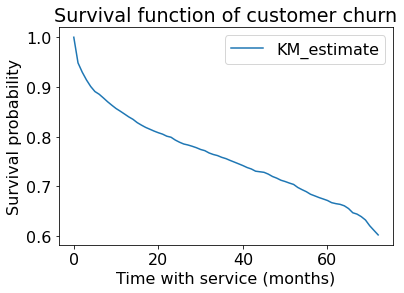

In [48]:
kmf.survival_function_.plot()
plt.title('Survival function of customer churn');
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- What is this plot telling us?
- It is the probability of survival over time.
- This is around 0.6 at the end, but...

In [49]:
np.mean(y_train == 'No')

0.7406285497917455

- ...but 73% of customers "survived" (did not churn) in our dataset. So, shouldn't our plot go down to 73%.
- It goes lower, to ~60%, because some customers churned in less than 70 months.
- Thus, the _probability_ of churning in 70 months is larger than our fraction who churned.
  - Or, conversely, the probability of survival after 70 months is lower than the fraction of stayed.

The key point here is that people _joined at different times_:

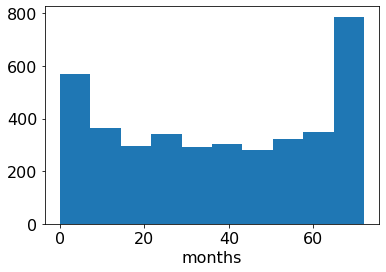

In [50]:
df_train[y_train == 'No']["tenure"].hist(grid=False);
plt.xlabel('months');

- Since the data was collected at a fixed time and these are the people who hadn't yet churned, those with larger `tenure` values here must have joined earlier.
- This is a bit subtle but an important point - questions?

Lifelines can also give us some "error bars":

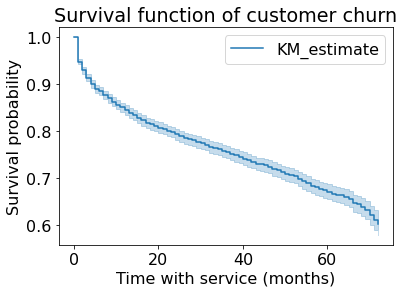

In [51]:
kmf.plot();
plt.title('Survival function of customer churn');
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- We already have some actionable information here.
- BTW, the [original paper by Kaplan and Meier](https://web.stanford.edu/~lutian/coursepdf/KMpaper.pdf) has been cited over 57000 times!

We can also create the K-M curve for different subgroups:

In [52]:
T = df_train_surv["tenure"]
E = df_train_surv["Churn"]
senior = df_train_surv["SeniorCitizen_1"] == 1

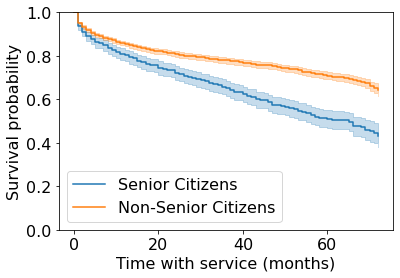

In [53]:
ax = plt.subplot(111)

kmf.fit(T[senior], event_observed=E[senior], label="Senior Citizens")
kmf.plot(ax=ax)

kmf.fit(T[~senior], event_observed=E[~senior], label="Non-Senior Citizens")
kmf.plot(ax=ax)

plt.ylim(0, 1);
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

- It looks like senior citizens churn more quickly than others.
- This is quite useful!

## Break (5 min)

REMINDER TO TURN ON RECORDING

## Cox proportional hazards model (10 min)

- The Cox proportional hazards model is a commonly used model that allows us to interpret how predictors influence a censored response. 
- You can think of it like linear regression for survival analysis: we will get a coefficient for each feature that tells us how it influences survival.
- It makes some strong assumptions (the proportional hazards assumption) that may not be true, but we won't go into this here.
- The proportional hazard model works multiplicately, like linear regression with log-transformed targets.

In [54]:
cph = lifelines.CoxPHFitter()
cph.fit(df_train_surv, duration_col='tenure', event_col='Churn');

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

![](img/mike_funtimes.png)

- Ok, going that [that URL](https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model), it seems the easiest solution is to add a penalizer.
  - FYI this is related to switching from `LinearRegression` to `Ridge`.
  - Adding `drop='first'` on our OHE might have helped with this.
  - (For 340 folks: we're adding regularization; `lifelines` adds both L1 and L2 regularization, aka elastic net)

In [55]:
cph = lifelines.CoxPHFitter(penalizer=0.1)
cph.fit(df_train_surv, duration_col='tenure', event_col='Churn');

In [56]:
cph_params = pd.DataFrame(cph.params_)
cph_params.sort_values(by="coef", ascending=False)

,coef
covariate,
Contract_Month-to-month,0.817158
OnlineSecurity_No,0.313812
OnlineBackup_No,0.300171
PaymentMethod_Electronic check,0.281481
TechSupport_No,0.212638
...,...
PaymentMethod_Credit card (automatic),-0.301786
OnlineSecurity_Yes,-0.332959
Contract_One year,-0.353184


- We can start to interpret these! 
- Looks like month-to-month leads to more churn, two-year contract leads to less churn; this makes sense!!!

In [57]:
# cph.baseline_hazard_ # baseline hazard

In [58]:
cph.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
MonthlyCharges,-0.003597,0.996409,0.040010,-0.082015,0.074820,0.921258,1.077691,-0.089912,9.283573e-01,0.107248
Partner_Yes,-0.413941,0.661040,0.049916,-0.511775,-0.316107,0.599430,0.728982,-8.292695,1.107109e-16,53.004052
Contract_Month-to-month,0.817158,2.264056,0.069154,0.681619,0.952697,1.977076,2.592693,11.816515,3.207163e-32,104.620401
Contract_One year,-0.353184,0.702448,0.077743,-0.505558,-0.200809,0.603169,0.818068,-4.542944,5.547410e-06,17.459754
Contract_Two year,-0.780959,0.457967,0.081116,-0.939943,-0.621974,0.390650,0.536884,-9.627673,6.109722e-22,70.471311
...,...,...,...,...,...,...,...,...,...,...
MultipleLines_Yes,-0.173226,0.840948,0.066395,-0.303358,-0.043093,0.738335,0.957822,-2.609004,9.080617e-03,6.782994
PaymentMethod_Bank transfer (automatic),-0.247674,0.780614,0.070818,-0.386475,-0.108873,0.679448,0.896844,-3.497331,4.699376e-04,11.055243
PaymentMethod_Credit card (automatic),-0.301786,0.739497,0.072179,-0.443253,-0.160318,0.641944,0.851873,-4.181086,2.901195e-05,15.072993


- Interpretation of the coefficients: changing a feature by 1 unit causes a multiplicative "change in hazard" by exp(coef). 
  - We're sweeping some details under the rug here.
- Note that, as discussed in Lecture 9, if $\textrm{coef}>0$ then $\exp(\textrm{coef})>1$.


Could we have gotten this type of information out of sklearn?

In [59]:
lr.fit(X_train, y_train)
lr_coefs = pd.DataFrame(data=np.squeeze(lr[1].coef_), index=X_train_enc.columns, columns=["Coefficient"])
lr_coefs.sort_values(by="Coefficient", ascending=False)

,Coefficient
Contract_Month-to-month,0.629730
TotalCharges,0.609741
InternetService_Fiber optic,0.566693
OnlineSecurity_No,0.290970
PaymentMethod_Electronic check,0.255438
...,...
MultipleLines_No,-0.205663
MonthlyCharges,-0.278485
InternetService_DSL,-0.434148
Contract_Two year,-0.622794


- There is some agreement, which is good.
- The coefficient for `tenure` - ha! Well that is definitely cheating!!! 
- But our survival model is much more useful.
  - Not to mention more correct.
- One thing we get with `lifelines` is confidence intervals on the coefficients:

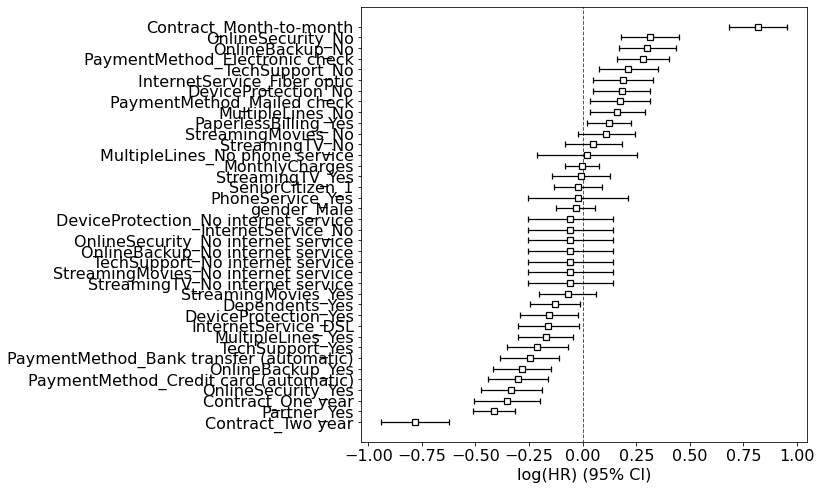

In [60]:
plt.figure(figsize=(8,8))
cph.plot();

- (We could probably get the same for logistic regression if using `statsmodels` instead of sklearn.)
- However, in general, I would be careful with all of this.
- Ideally we would have more statistical training when using `lifelines` - there is a lot that can go wrong.
  - It comes with various diagnostics as well.
- But I think it's very useful to know about survival analysis and the availability of software to deal with it.
- Oh, and there are lots of other nice plots.

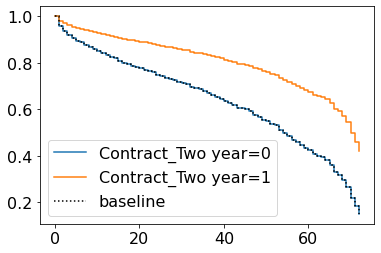

In [61]:
cph.plot_partial_effects_on_outcome('Contract_Two year', [0, 1]);

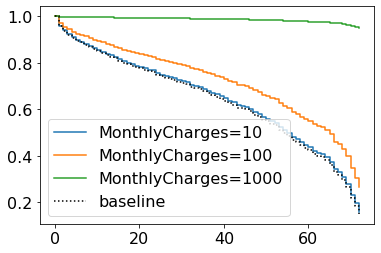

In [62]:
cph.plot_partial_effects_on_outcome('MonthlyCharges', [10, 100, 1000]);

- That's the thing with linear models, they can't stop the growth.
- We have a negative coefficient associated with `MonthlyCharges`

In [63]:
cph_params.loc["MonthlyCharges"]

coef   -0.003597
Name: MonthlyCharges, dtype: float64

If your monthly charges are huge, it takes this to the extreme and thinks you'll basically never churn.

## Prediction (10 min)

- We can use survival analysis to make predictions as well.
- Here is the expected number of months to churn for the first 5 customers in the test set:

In [64]:
cph.predict_expectation(df_test_surv).head()

941     35.399514
1404    69.120668
5515    68.453006
3684    28.166816
7017    68.022376
dtype: float64

Survival curves for first 5 customers in the test set:

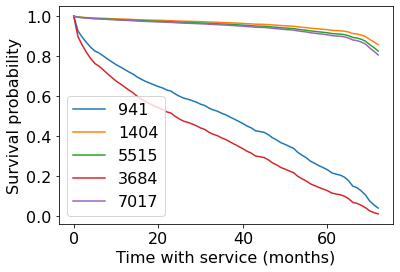

In [65]:
cph.predict_survival_function(df_test_surv[:5]).plot();
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');

From `predict_survival_function` documentation:

> Predict the survival function for individuals, given their covariates. This assumes that the individual just entered the study (that is, we do not condition on how long they have already lived for.) 

So these curves are "starting now".

- There's no probability prerequisite for this course, so this is optional material.
- But you can do some interesting stuff here with conditional probabilities.
- "Given that a customer has been here 5 months, what's the outlook?"
  - It will be different than for a new customer. 
  - Thus, we might still want to predict for the non-churned customers in the training set!
  - Not something we really thought about with our traditional supervised learning.

In [66]:
df_train_surv_not_churned = df_train_surv[df_train_surv["Churn"] == 0]

In [67]:
df_train_surv_not_churned[:1]["tenure"]

6464    50.0
Name: tenure, dtype: float64

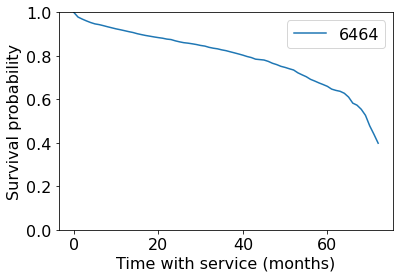

In [68]:
cph.predict_survival_function(df_train_surv_not_churned[:1]).plot();
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');
plt.ylim([0,1]);

We can _condition_ on the person having been around for 50 months.

In [69]:
cph.predict_survival_function(df_train_surv_not_churned[:1], conditional_after=20)

,6464
0.0,1.000000
1.0,0.996929
2.0,0.992320
3.0,0.989908
4.0,0.983341
...,...
68.0,0.450575
69.0,0.450575
70.0,0.450575
71.0,0.450575


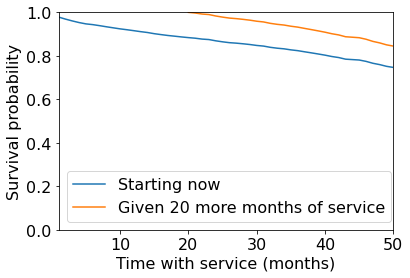

In [70]:
plt.figure()
cph.predict_survival_function(df_train_surv_not_churned[:1]).plot(ax=plt.gca());
preds = cph.predict_survival_function(df_train_surv_not_churned[:1], conditional_after=20)
plt.plot(preds.index[20:], preds.values[:-20])
plt.xlabel('Time with service (months)');
plt.ylabel('Survival probability');
plt.legend(["Starting now", "Given 20 more months of service"])
plt.ylim([0,1]);
plt.xlim([1,50]);

- Look at how the survival function (and expected lifetime) is much longer _given_ that the customer has already lasted 20 months.

So, we can set this to their actual tenure so far to get a prediciton of what will happen going forward:

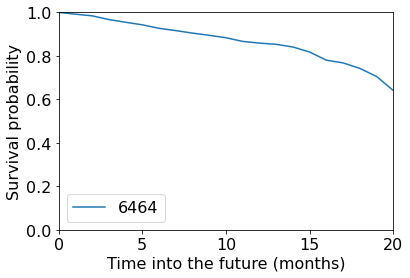

In [71]:
cph.predict_survival_function(df_train_surv_not_churned[:1], conditional_after=df_train_surv_not_churned[:1]["tenure"]).plot();
plt.xlabel('Time into the future (months)');
plt.ylabel('Survival probability');
plt.ylim([0,1]);
plt.xlim([0,20]);

- Another useful application: you could ask what is the [customer lifetime value](https://en.wikipedia.org/wiki/Customer_lifetime_value).
  - Basically, how much money do you expect to make off this customer between now and when they churn?
- With regular supervised learning, tenure was a feature and we could only predict whether or not they had churned by then.

## Other approaches / what did we not cover? (10 min)


#### Measures of model accuracy

By default score returns "partial log likelihood":

In [72]:
cph.score(df_train_surv)

-1.864621279367729

In [73]:
cph.score(df_test_surv)

-1.727691684168186

We can look at the "concordance index":

In [74]:
cph.concordance_index_

0.8626990298786501

In [75]:
cph.score(df_train_surv, scoring_method="concordance_index")

0.8626990298786501

In [76]:
cph.score(df_test_surv, scoring_method="concordance_index")

0.8545229998086725

From the documentation [here](https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-selection-and-calibration-in-survival-regression):

> Another censoring-sensitive measure is the concordance-index, also known as the c-index. This measure evaluates the accuracy of the ranking of predicted time. It is in fact a generalization of AUC, another common loss function, and is interpreted similarly:
> 
> - 0.5 is the expected result from random predictions,
> - 1.0 is perfect concordance and,
> - 0.0 is perfect anti-concordance (multiply predictions with -1 to get 1.0)
> 
> [Here](https://stats.stackexchange.com/a/478305/11867) is an excellent introduction & description of the c-index for new users.


In [77]:
# cph.log_likelihood_ratio_test()

In [78]:
# cph.check_assumptions(df_train_surv)

#### Other approaches

There are many other approaches to modelling in survival analysis:

- Time-varying proportional hazards.
  - What if some of the features change over time, e.g. plan type, number of lines, etc.
- Approaches based on deep learning, e.g. the [pysurvival](https://square.github.io/pysurvival/) package.
- Random survival forests.
- And more...

#### Types of censoring
There are also various types and sub-types of censoring we didn't cover:

- Sub-types within right censoring
  - Did everyone join at the same time?
  - Other there other reasons the data might be censored at random times, e.g. the person died?
- Left censoring
- Interval censoring

## True/False questions

1. If all customers joined a service at the same time (hypothetically), then censoring would not be an issue.
3. The Cox proportional hazards model (`cph` above) assumes the effect of a feature is the same for all customers and over all time.
4. Survival analysis can be useful even without a "deployment" stage.


## References

Some people working with this same dataset:

- https://medium.com/@zachary.james.angell/applying-survival-analysis-to-customer-churn-40b5a809b05a
- https://towardsdatascience.com/churn-prediction-and-prevention-in-python-2d454e5fd9a5 (Cox)
- https://towardsdatascience.com/survival-analysis-in-python-a-model-for-customer-churn-e737c5242822
- https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e

lifelines documentation: 
- https://lifelines.readthedocs.io/en/latest/Survival%20analysis%20with%20lifelines.html
- https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html#introduction-to-survival-analysis